In [1]:
# run whole script
%run 03_safe_execution.ipynb

SQL blocked by guardrails: Forbidden SQL operation detected

Query: ```SELECT * FROM orders```
Valid: True
Reason: SQL is safe to execute

Query: WITH t AS (SELECT * FROM orders) SELECT * FROM t
Valid: True
Reason: SQL is safe to execute

Query: DELETE FROM orders
Valid: False
Reason: Forbidden SQL operation detected

Query: DROP TABLE products
Valid: False
Reason: Forbidden SQL operation detected

Query: SELECT * FROM orders; DELETE FROM orders
Valid: False
Reason: Forbidden SQL operation detected

Query: UPDATE orders SET order_dow = 1
Valid: False
Reason: Forbidden SQL operation detected


In [2]:
import yaml
from pathlib import Path
from typing import Tuple, Dict, Any, TypedDict, Optional

from langgraph.graph import StateGraph, END 

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()


True

## Database Connection

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path("D:/code/text-to-sql-agent")))

from src.db.db_connection import get_db_connection

conn = get_db_connection()
cursor = conn.cursor()

## Load Schema

In [4]:
SCHEMA_PATH = Path("../src/schema/schema_summary.yaml")

with open(SCHEMA_PATH, "r", encoding="utf-8") as f:
    schema_context: Dict[str, Any] = yaml.safe_load(f)

schema_context.keys()


dict_keys(['tables', 'hints', 'common_joins'])

## Initialize LLm

In [5]:
from langchain_openai import ChatOpenAI
import os

def load_llm():
    return ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0,
        openai_api_key=os.getenv("OPENAI_API_KEY")
    )

def call_llm(prompt: str) -> str:
    llm = load_llm()
    response = llm.invoke(prompt)
    return response.content.strip()


## Prompts

In [17]:
# Optimized SQL generation prompt

def build_optimized_prompt(
    question: str,
    schema: Dict[str, Any]
) -> str:
    return f"""
You are an expert PostgreSQL SQL generator.

CRITICAL RULES:
- Output ONLY one SQL SELECT query
- Do NOT include markdown, backticks, or explanations
- Use ONLY tables and columns from the schema
- Follow join templates strictly
- Never invent joins or columns
- Prefer correctness over brevity

Database schema with semantics:
{schema}

User question:
{question}

SQL:
""".strip()


# Optimized correction prompt

def build_optimized_correction_prompt(
    question: str,
    schema: Dict[str, Any],
    previous_sql: str,
    error_reason: str
) -> str:
    return f"""
The SQL query below is INVALID.

Failure reason:
{error_reason}

Rules to fix:
- Use schema exactly as provided
- Follow join templates
- Do not invent columns or tables
- Output ONLY corrected SQL

Schema:
{schema}

Question:
{question}

Invalid SQL:
{previous_sql}

Corrected SQL:
""".strip()

def build_answer_validation_prompt(
    question: str,
    sql: str,
    results: list
) -> str:
    """
    Creates a prompt for LLM to validate if results answer the question.
    """
    # Limit results to first 10 rows for efficiency
    sample_results = results[:10]
    
    return f"""
You are a SQL result validator. Your job is to determine if the SQL query results actually answer the user's question.

CRITICAL RULES:
- Output ONLY valid JSON with two fields: "valid" (boolean) and "reason" (string)
- Check if the query targeted the RIGHT tables and columns
- Check if the result structure makes sense for the question
- Check if the values are plausible (no negative counts, reasonable magnitudes)
- Do NOT execute code or generate new SQL

User Question:
{question}

SQL Query Executed:
{sql}

Results (first 10 rows):
{sample_results}

Analysis:
1. Does the SQL query the correct tables/columns for this question?
2. Do the returned values semantically match what was asked?
3. Are the results plausible and reasonable?

Output JSON format:
{{
    "valid": true/false,
    "reason": "explanation of why valid or invalid"
}}

JSON:
""".strip()


In [7]:
# # -------------------------------------------------------
# # Generate SQL (optimized)
# # -------------------------------------------------------

def generate_sql_optimized(question: str) -> str:
    prompt = build_optimized_prompt(question, schema_context)
    raw_sql = call_llm(prompt)
    return raw_sql


In [8]:
class SQLAgentState(TypedDict):
    question: str
    sql: Optional[str]
    valid: bool
    reason: Optional[str]
    retries: int
    executed: bool          
    results: Optional[list]

In [9]:
def generate_sql_node(state: SQLAgentState) -> SQLAgentState:
    print("🔄 Generating SQL...")
    raw_sql = generate_sql_optimized(state["question"])
    sql = clean_sql(raw_sql)
    print(f"Generated: {sql[:100]}...")
    return {**state, "sql": sql}


In [10]:
def validate_sql_node(state: SQLAgentState) -> SQLAgentState:
    print("🔍 Validating syntax...")
    is_valid, reason = validate_sql(state["sql"])
    print(f"Syntax valid: {is_valid}")
    if not is_valid:
        print(f"Reason: {reason}")
    return {**state, "valid": is_valid, "reason": None if is_valid else reason, "executed": False}

In [11]:
def execute_sql_node(state: SQLAgentState) -> SQLAgentState:
    print("⚡ Executing SQL...")
    try:
        cursor.execute(state["sql"])
        results = cursor.fetchall()
        print(f"✅ Executed! Got {len(results)} rows")
        return {**state, "executed": True, "results": results, "reason": None}
    except Exception as e:
        print(f"❌ Execution failed: {str(e)[:100]}")
        return {**state, "executed": False, "results": None, "reason": f"Execution error: {str(e)}"}


In [12]:
def validate_execution_node(state: SQLAgentState) -> SQLAgentState:
    print("🔍 Validating execution...")
    if not state["executed"]:
        print("Failed - execution error")
        return {**state, "valid": False}
    if not state["results"] or len(state["results"]) == 0:
        print("Failed - no results")
        return {**state, "valid": False, "reason": "Query returned no results"}
    print("✅ Validation passed!")
    return {**state, "valid": True, "reason": None}

In [13]:
def correct_sql_node(state: SQLAgentState) -> SQLAgentState:
    print(f"🔧 Correcting SQL (retry {state['retries'] + 1}/{MAX_RETRIES})...")
    prompt = build_optimized_correction_prompt(
        question=state["question"],
        schema=schema_context,
        previous_sql=state["sql"],
        error_reason=state["reason"]
    )
    corrected_sql = call_llm(prompt)
    sql = clean_sql(corrected_sql)
    print(f"Corrected: {sql[:100]}...")
    return {**state, "sql": sql, "retries": state["retries"] + 1}

In [18]:
def validate_answer_node(state: SQLAgentState) -> SQLAgentState:
    """
    Validates if the SQL results actually answer the user's question.
    Uses LLM to check semantic correctness.
    """
    print("🔍 Validating answer relevance...")
    
    if not state["executed"] or not state["results"]:
        print("⚠️ Cannot validate - no results to check")
        return {**state, "valid": False, "reason": "No results to validate"}
    
    # Build validation prompt
    prompt = build_answer_validation_prompt(
        question=state["question"],
        sql=state["sql"],
        results=state["results"]
    )
    
    # Get LLM judgment
    response = call_llm(prompt)
    
    # Parse response (expecting JSON format)
    try:
        import json
        validation = json.loads(response)
        is_valid = validation.get("valid", False)
        reason = validation.get("reason", "Unknown validation failure")
        
        if is_valid:
            print("✅ Answer validates correctly!")
        else:
            print(f"❌ Answer validation failed: {reason}")
        
        return {**state, "valid": is_valid, "reason": None if is_valid else reason}
    
    except json.JSONDecodeError:
        print("⚠️ Failed to parse validation response")
        return {**state, "valid": False, "reason": "Validation parsing error"}


In [20]:
MAX_RETRIES = 2

def route_after_syntax_check(state: SQLAgentState):
    """Route after pre-execution validation"""
    if state["valid"]:
        return "execute_sql"
    if state["retries"] >= MAX_RETRIES:
        return END
    return "correct_sql"

def route_after_execution(state: SQLAgentState):
    """Route after execution - now goes to answer validation"""
    if state["executed"]:
        return "validate_answer"  # NEW: validate the answer
    if state["retries"] >= MAX_RETRIES:
        return END
    return "correct_sql"

def route_after_answer_validation(state: SQLAgentState):
    """Route after answer validation"""
    if state["valid"]:
        return END  # Success!
    if state["retries"] >= MAX_RETRIES:
        return END  # Give up
    return "correct_sql"  # Try again with better context

In [21]:
graph = StateGraph(SQLAgentState)

# Nodes
graph.add_node("generate_sql", generate_sql_node)
graph.add_node("validate_sql", validate_sql_node)
graph.add_node("execute_sql", execute_sql_node)
graph.add_node("validate_answer", validate_answer_node)  # NEW
graph.add_node("correct_sql", correct_sql_node)

# Entry point
graph.set_entry_point("generate_sql")

# Flow
graph.add_edge("generate_sql", "validate_sql")

graph.add_conditional_edges(
    "validate_sql",
    route_after_syntax_check,
    {
        "execute_sql": "execute_sql",
        "correct_sql": "correct_sql",
        END: END
    }
)

graph.add_conditional_edges(
    "execute_sql",
    route_after_execution,
    {
        "validate_answer": "validate_answer",  # NEW: route to answer validation
        "correct_sql": "correct_sql",
        END: END
    }
)

# NEW: Answer validation routing
graph.add_conditional_edges(
    "validate_answer",
    route_after_answer_validation,
    {
        "correct_sql": "correct_sql",
        END: END
    }
)

graph.add_edge("correct_sql", "validate_sql")

# Compile
sql_agent = graph.compile()

In [22]:
initial_state: SQLAgentState = {
    "question": "how many products are there?",
    "sql": None,
    "valid": False,
    "reason": None,
    "retries": 0,
    "executed": False,
    "results": None
}

final_state = sql_agent.invoke(initial_state)

# Updated output
if final_state["valid"] and final_state["executed"]:
    print("\n" + "="*50)
    print("✅ SUCCESS - Answer Validated!")
    print("="*50)
    print(f"Question: {final_state['question']}")
    print(f"SQL: {final_state['sql']}")
    print(f"Results: {final_state['results'][:5]}")
else:
    print("\n" + "="*50)
    print("❌ FAILED")
    print("="*50)
    print(f"Reason: {final_state['reason']}")
    print(f"Retries used: {final_state['retries']}/{MAX_RETRIES}")

🔄 Generating SQL...
Generated: select count(*) as product_count from products;...
🔍 Validating syntax...
Syntax valid: True
⚡ Executing SQL...
✅ Executed! Got 1 rows
🔍 Validating answer relevance...
✅ Answer validates correctly!

✅ SUCCESS - Answer Validated!
Question: how many products are there?
SQL: select count(*) as product_count from products;
Results: [(49688,)]


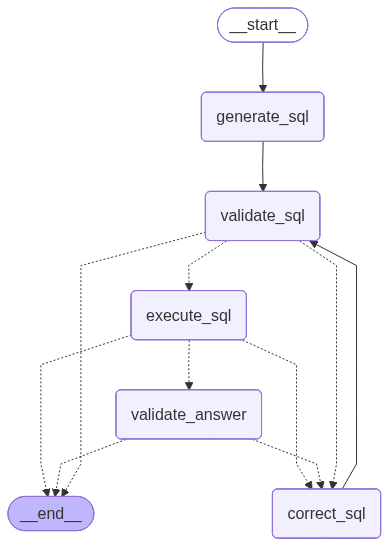

In [23]:
from IPython.display import Image, display

try:
    display(Image(sql_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visual diagram failed: {e}")
    print("You may need to install: pip install pygraphviz")